In [72]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

device='cuda'

In [53]:
# define resnet model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, downsample_factor=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if downsample_factor > 1:
                inputs = downsample_resolution(inputs, downsample_factor)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

def downsample_resolution(images, factor):
    h, w = images.shape[2:]  # height and width of images
    new_h, new_w = h // factor, w // factor
    downsampled = np.zeros((images.shape[0], images.shape[1], new_h, new_w))  # output shape

    for i in range(new_h):
        for j in range(new_w):
            patch = images[:, :, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            avg_patch = np.mean(patch, axis=(2, 3))  # mean across height and width
            downsampled[:, :, i, j] = avg_patch

    return downsampled

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs


def estimate_mi(model, dataloader, downsample_factor=1):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if downsample_factor > 1:
                inputs = downsample_resolution(inputs, downsample_factor)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            predicted_labels.append(preds)

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    mi = lmi.ksg.midd(true_labels, predicted_labels)
    mean_mi = np.nanmean(mi)
    print(f"Estimated Mutual Information: {mean_mi:.4f}")
    return mean_mi


In [54]:
MIs = []

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((224, 224)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform,)


N = len(Caltech101)

train_set, val_set = torch.utils.data.random_split(Caltech101, [1280, N-1280])
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
# # extract images and labels
# images, labels = [], []
# for batch in data_loader:
#     images.append(batch[0].numpy())
#     labels.append(batch[1].numpy())
# images = np.concatenate(images, axis=0)
# labels = np.concatenate(labels, axis=0)

# print(labels)
# downsample resolution :)


Files already downloaded and verified


In [55]:

# different downsampling factors
factors = [2, 4, 5, 8, 10, 20, 50, 100]
print("factors to process:", factors)

# process each factor
for factor in factors:
    print(f"downsampling by factor {factor}...")

    model = ResNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=5, downsample_factor=factor)

    # estimate mutual info
    mi = estimate_mi(model, val_loader, downsample_factor=factor)
    mean_mi = np.nanmean(mi)
    MIs.append(mean_mi)
    print(f"factor {factor} -> MI: {mean_mi:.4f}")

print("mutual information results:", MIs)

factors to process: [2, 4, 5, 8, 10, 20, 50, 100]
downsampling by factor 2...
Epoch 1/5, Loss: 4.2297


KeyboardInterrupt: 

In [5]:
import pandas as pd
import seaborn as sns

In [6]:
d = {"MIs" : MIs, 
     "Downsampling Factors" : factors
     }

df = pd.DataFrame(data=d)
df

,MIs,Downsampling Factors
0,5.584250,1
1,5.320148,2
2,4.078158,4
3,3.755498,5
4,2.682305,8
5,2.452483,10
6,1.802084,20
7,1.226278,50
8,0.895387,100


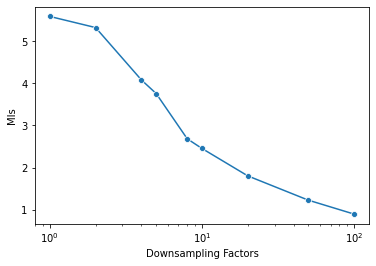

In [7]:
sns.lineplot(x="Downsampling Factors", y="MIs", data=df, marker='o')
plt.xscale('log')

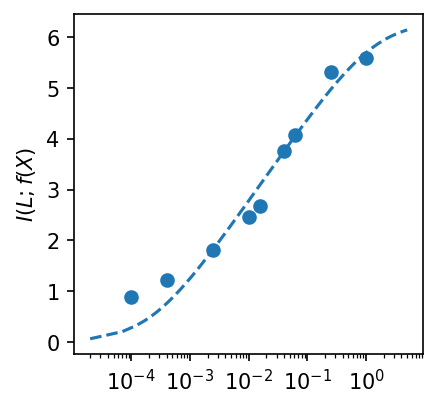

In [73]:
from scipy.optimize import curve_fit
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

x_data = 1/(df['Downsampling Factors']**2)
y_data = df['MIs']
popt, pcov = curve_fit(info_scaling, x_data, y_data, 
                        p0 = [10**-2, 10**-2], bounds=[(0, 0), (np.inf, np.inf)])

x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)

fig = plt.figure(figsize=(3,3), dpi=150)
# plt.xlabel(r'$f^{-2}$')
plt.ylabel(r'$I(L; f(X)$')
plt.scatter(x_data, y_data)
plt.plot(x_fit, info_scaling(x_fit, *popt), linestyle='--')
plt.xscale('log')

In [35]:
images, labels = [], []
for batch in data_loader:
    images.append(batch[0].numpy())
    labels.append(batch[1].numpy())
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


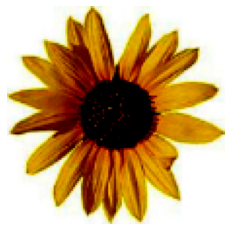

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


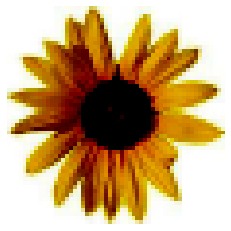

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


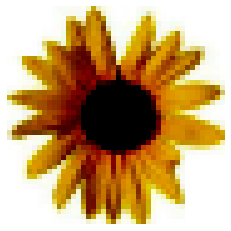

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


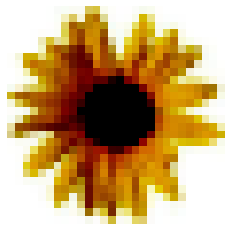

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


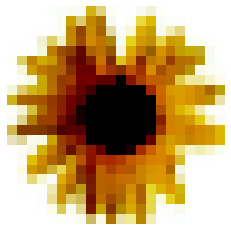

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


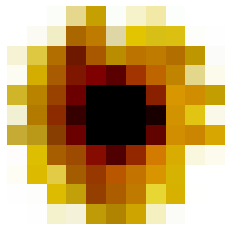

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


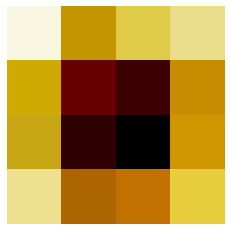

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


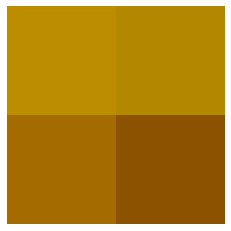

In [61]:
# label 90 is the good label


for f in factors:
    downsampled = downsample_resolution(images[0], f)
    for i in range(50, len(images[0])):
        if labels[0][i] == 90:
            plt.axis('off')
            plt.imshow(downsampled.transpose(0, 2, 3, 1)[i])
            plt.show()
            break